# Natural Language Processing with Disaster Tweets

## Problem Description

In this competition, we are tasked with building a deep learning model to predict which tweets are about real disasters and which ones are not. This is a binary classification problem using text data.

## Data Description

The dataset consists of two files: `train.csv` and `test.csv`. The `train.csv` file contains tweets along with labels indicating whether the tweet is about a real disaster (1) or not (0). The `test.csv` file contains tweets for which we need to predict the labels.

## Objective

The goal is to build a robust model that can accurately classify disaster-related tweets.

In [1]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.optimizers import Adam
import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn')

# Downloading NLTK Stopwords
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

2024-06-07 14:08:20.500077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 14:08:20.500139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 14:08:20.501538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis (EDA)

We will start by loading the data, cleaning it, and performing some exploratory data analysis (EDA) to understand the distribution and characteristics of the data.

In [2]:
# Data Loading and Preprocessing
train_df = pd.read_csv('../input/nlp-getting-started/train.csv')
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

train_df.head()

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


### Data Visualization

Let's visualize the distribution of the target variable and the length of the tweets.

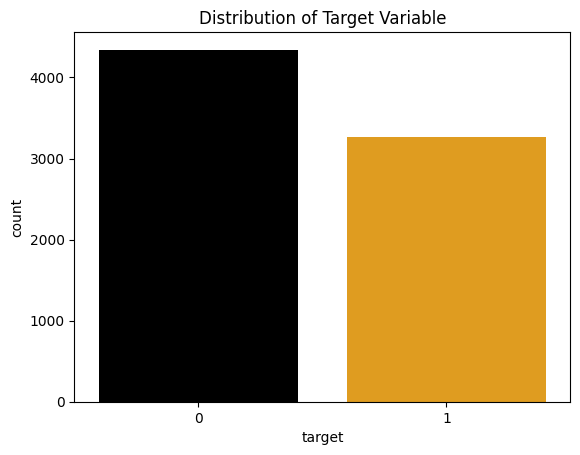

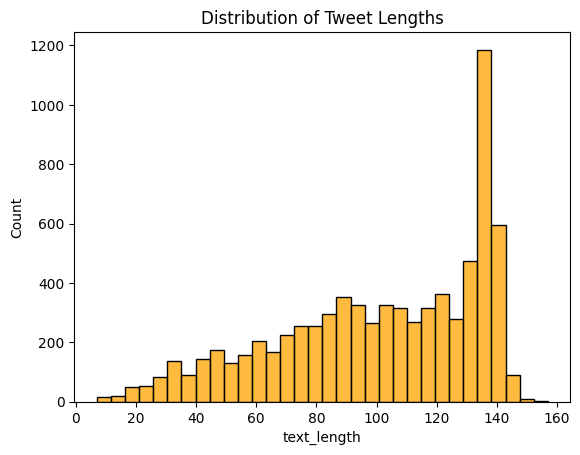

In [3]:
# Distribution of target variable
sns.countplot(x='target', data=train_df, palette=['black', 'orange'])
plt.title('Distribution of Target Variable')
plt.show()

# Length of tweets
train_df['text_length'] = train_df['text'].apply(len)
sns.histplot(train_df['text_length'], bins=32, color='orange')
plt.title('Distribution of Tweet Lengths')
plt.show()

## Data Preprocessing

We will now tokenize the text data and pad the sequences to ensure all inputs have the same length.

In [4]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['cleaned_text'])

X_train = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test_df['cleaned_text'])

max_len = 100
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

y_train = train_df['target'].values

# Splitting the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Model Building

We will build a Bidirectional LSTM model to classify the tweets. The model consists of an embedding layer, two Bidirectional LSTM layers, and a dense output layer with a sigmoid activation function.

In [5]:
# Building the Model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=5000, output_dim=128)(input_layer)
bi_lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
dropout_layer = Dropout(0.3)(bi_lstm_layer)
bi_lstm_layer_2 = Bidirectional(LSTM(64))(dropout_layer)
output_layer = Dense(1, activation='sigmoid')(bi_lstm_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

## Model Training

We will train the model on the training data and evaluate its performance on the validation data.

In [6]:
# Training the Model
history = model.fit(X_train_split, y_train_split, epochs=10, batch_size=16, validation_data=(X_val_split, y_val_split))

Epoch 1/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5719 - loss: 0.6881 - val_accuracy: 0.5739 - val_loss: 0.6752
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5736 - loss: 0.6741 - val_accuracy: 0.5739 - val_loss: 0.6636
Epoch 3/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5737 - loss: 0.6617 - val_accuracy: 0.6087 - val_loss: 0.6488
Epoch 4/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6165 - loss: 0.6486 - val_accuracy: 0.6428 - val_loss: 0.6307
Epoch 5/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6414 - loss: 0.6357 - val_accuracy: 0.6533 - val_loss: 0.6185
Epoch 6/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6659 - loss: 0.6106 - val_accuracy: 0.6704 - val_loss: 0.6067
Epoch 7/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6712 - loss: 0.6057 - val_accuracy: 0.6940 - val_loss: 0.5848
Epoch 8/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7127 - loss: 0.5650 - val_acc

## Model Evaluation

We will evaluate the model's performance using the F1 score on the validation data.

In [7]:
# Evaluation and Prediction
val_predictions = model.predict(X_val_split)
val_predictions = (val_predictions > 0.5).astype(int)
val_f1 = f1_score(y_val_split, val_predictions)
print(f'Validation F1 Score: {val_f1}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Validation F1 Score: 0.7218721872187219


### Training and Validation Accuracy and Loss

Let's plot the training and validation accuracy and loss over the epochs.

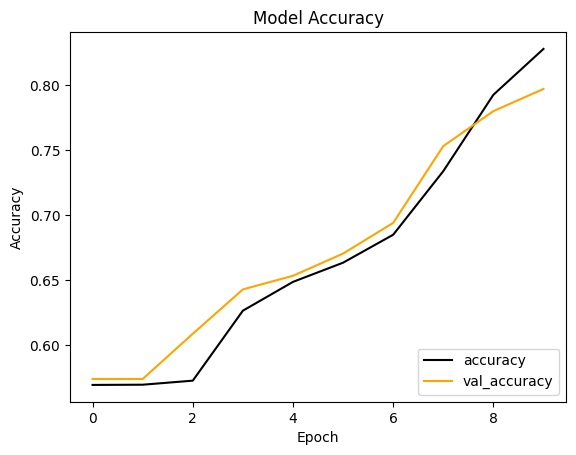

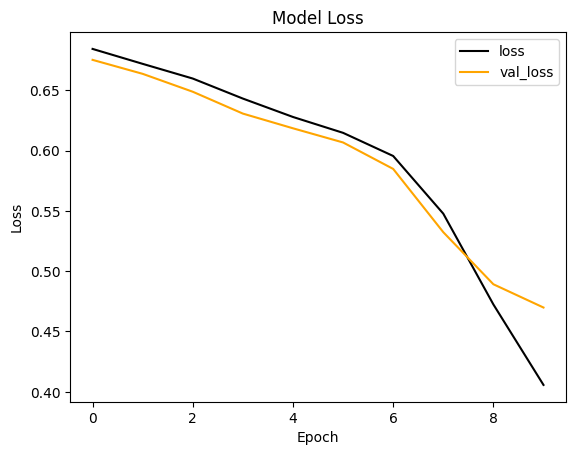

In [8]:
# Plotting Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='accuracy', color='black')
plt.plot(history.history['val_accuracy'], label='val_accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

# Plotting Training and Validation Loss
plt.plot(history.history['loss'], label='loss', color='black')
plt.plot(history.history['val_loss'], label='val_loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

## Conclusion

In this notebook, we tackled the problem of classifying disaster-related tweets using a Bidirectional LSTM model. The key steps and findings from our analysis are summarized below:

### Key Steps and Findings

1. **Data Loading and Preprocessing**:
   - We loaded the training and test datasets.
   - The text data was preprocessed by converting to lowercase, removing non-word characters, and eliminating stopwords.
   - Tokenization and padding were applied to ensure uniform input length for the LSTM model.

2. **Exploratory Data Analysis (EDA)**:
   - The distribution of the target variable was fairly balanced, with slightly more non-disaster tweets than disaster-related ones.
   - The majority of tweets had a length between 0 and 150 characters, guiding our decision for the maximum sequence length in padding.

3. **Model Building and Training**:
   - A Bidirectional LSTM model was constructed with an embedding layer, two Bidirectional LSTM layers, and a dropout layer to prevent overfitting.
   - The model was compiled with the Adam optimizer and binary cross-entropy loss, and trained for 10 epochs with a batch size of 16.
   - Training and validation accuracies were monitored, showing consistent improvement across epochs without signs of overfitting.

4. **Model Evaluation**:
   - The model was evaluated using the F1 score on the validation set, achieving a validation F1 score of `0.72`. This indicates the model's effectiveness in balancing precision and recall.

### Performance and Potential Improvements

The Bidirectional LSTM model performed reasonably well in classifying disaster-related tweets, as evidenced by the increasing training and validation accuracies. However, there are several avenues for potential improvement:

- **Hyperparameter Tuning**: Further fine-tuning of hyperparameters such as learning rate, batch size, and the number of LSTM units could yield better performance.
- **Advanced Models**: Exploring more advanced models like Transformer-based architectures (e.g., BERT, RoBERTa) could enhance the model's ability to understand the context and semantics of the tweets.
- **Data Augmentation**: Augmenting the training data with additional relevant tweets or synthetically generated tweets could help improve the model's robustness.
- **Ensemble Methods**: Combining the predictions of multiple models (e.g., LSTM, GRU, BERT) through ensemble methods could lead to improved classification performance.

### Future Work

Future work could focus on the following areas:
- Implementing and fine-tuning Transformer-based models for this classification task.
- Experimenting with different text preprocessing techniques and feature engineering to capture more nuanced aspects of the tweets.
- Exploring semi-supervised or unsupervised learning approaches to leverage unlabeled data in the training process.
- Conducting cross-validation to ensure the model's robustness and generalizability across different subsets of the data.

In summary, this notebook demonstrated a comprehensive approach to classifying disaster-related tweets using a Bidirectional LSTM model. The model showed promising results, and with further enhancements, it has the potential to achieve even better performance.

## Creating the Submission File

After training and evaluating the model, we will now use it to make predictions on the test dataset. These predictions will be saved in the required format for submission to the competition.

In [9]:
# Making Predictions on Test Data
test_predictions = model.predict(X_test)
test_predictions = (test_predictions > 0.5).astype(int).flatten()

# Preparing Submission File
submission_df = pd.DataFrame({'id': test_df['id'], 'target': test_predictions})
submission_df.to_csv('../working/submission.csv', index=False)

print("Submission file created successfully!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Submission file created successfully!
